In [1]:
# instalação dos pacotes necessários na versão mais nova
%pip install -U scikit-learn pandas numpy seaborn spacy nltk lightgbm --quiet

#preparing spacy, hang on we're downloading over 400MB of data :)
%pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.3.0/en_core_web_lg-3.3.0-py3-none-any.whl" --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import pandas as pd

import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline

#estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
import lightgbm as lgb

#graphs
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# # aqui a gente cala a boca do sklearn
# # importa o filtro
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning


# # monta o filtro
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UndefinedMetricWarning)

In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
df = pd.read_csv('data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [7]:
nlp = spacy.load('en_core_web_sm')

texto = df.Sentence[0]

print('--------------')
print('Texto original')
print(texto)

doc = nlp(texto)
# Cada token que estiver dentro do documento você mantem caso não seja uma stopword ou pontuação(punch)  
tokens_filtrado = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]

print('--------------')
print('Remoção de stopwords e pontuação')
print(tokens_filtrado)

lemmas = [token.lemma_.lower().strip() for token in tokens_filtrado]

print('--------------')
print('Lemmatization')
print(lemmas)

--------------
Texto original
The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
--------------
Remoção de stopwords e pontuação
[GeoSolutions, technology, leverage, Benefon, GPS, solutions, providing, Location, Based, Search, Technology, Communities, Platform, location, relevant, multimedia, content, new, powerful, commercial, model]
--------------
Lemmatization
['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'provide', 'location', 'based', 'search', 'technology', 'communities', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model']


----


### 1.a Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro.

In [8]:
# Criamos uma classe para gerenciar X e y
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Esta funcao remove espacos em branco no inicio e
# no fim do texto e converte todo o texto em letras
# minusculas
def clean_text(texto):     
    return texto.strip().lower()

# Esta funcao remove todas as stopwords e pontuacoes
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens 
#criamos um objeto CountVectorizer para vetorizar cada texto
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1))

#criamos um modelo SVM
classifier = SVC()


In [9]:

# Separando em X e y
X = df.Sentence
y = df.Sentiment

# Separando em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construindo uma pipeline
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])


pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)



1.b Quais foram os valores de acurácia, precisão e sensitividade deste modelo? (3.0 pontos)

In [10]:

print(round(accuracy_score(y_test, y_pred), 3))
print(round(precision_score(y_test, y_pred, average='macro'), 3))
print(round(recall_score(y_test, y_pred, average='macro'), 3))

0.681
0.596
0.526


----

##### 2 Use o seu modelo para classificar os seguintes textos extraídos do site Financial Times. Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir? (1.0 ponto)

In [11]:
new_data_dict = {
                  "Sentence": ["Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety.",
                          "China opens up bond market in bid to woo foreign investors.",
                          "HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this.",
                          "Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism.",
                          "Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate."],
                  "Sentiment": ["negative", "neutral", "negative", "negative", "neutral"]        
                          }
                          
new_data = pd.DataFrame(new_data_dict)

new_data.head()

,Sentence,Sentiment
0,"Central banks’ rate rises, geopolitical risk a...",negative
1,China opens up bond market in bid to woo forei...,neutral
2,HM Revenue & Customs says residents had £850bn...,negative
3,Japan’s horrifying crop of data falsification ...,negative
4,"Despite internal problems, the group continues...",neutral


In [ ]:
y_pred2 = pipe.predict(new_data['Sentence'])
print(round(accuracy_score(new_data['Sentiment'], y_pred), 3))
print(round(precision_score(new_data['Sentiment'], y_pred, average='macro'), 3))
print(round(recall_score(new_data['Sentiment'], y_pred, average='macro'), 3))

In [13]:
sentences = new_data_dict['Sentence']
sentiments_or = new_data_dict['Sentiment']
sentiments_pred = y_pred2

values_dict = {"Sentence": sentences, "Original Sentiment": sentiments_or, "Predicted Sentiment": sentiments_pred}

values_df = pd.DataFrame(values_dict)

values_df['Divergence'] = values_df["Predicted Sentiment"] != values_df["Original Sentiment"]

values_df

,Sentence,Original Sentiment,Predicted Sentiment,Divergence
0,"Central banks’ rate rises, geopolitical risk a...",negative,positive,True
1,China opens up bond market in bid to woo forei...,neutral,neutral,False
2,HM Revenue & Customs says residents had £850bn...,negative,neutral,True
3,Japan’s horrifying crop of data falsification ...,negative,neutral,True
4,"Despite internal problems, the group continues...",neutral,neutral,False


In [14]:
values_df['Divergence'].value_counts()

True     3
False    2
Name: Divergence, dtype: int64

----

#### 3 Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. (3.0 pontos)


a. Extraia de todos os textos as entidades, há quantas entidades? (0.6 pontos) 


In [15]:
entities = 0
for row in range(len(df)):
  doc = nlp(df['Sentence'][row])
  for ent in doc.ents:
    entities += 1

           
print(entities)

14467


b. Quantas entidades são empresas? (0.6 pontos)


In [16]:
orgs = {'original_index': [], 'entity': [], 'sentiment': []}
for row in range(df.shape[0]):
  doc = nlp(df['Sentence'][row])
  for ent in doc.ents:
    if ent.label_ == 'ORG':
      orgs['original_index'].append(row)
      orgs['entity'].append(ent.text)
      orgs['sentiment'].append(df['Sentiment'][row])

ents = pd.DataFrame(orgs)


In [17]:
print(f'O numero de entidades que são empresa é de',len(np.unique(ents['entity'])))

O numero de entidades que são empresa é de 2166


 c. Quais são as três empresas mais citadas? (0.6 pontos) 
 

In [18]:
ents.entity.value_counts(sort = True)

Nokia                                            75
EUR                                              72
EPS                                              60
Group                                            33
OMX                                              31
                                                 ..
BAVARIA Industriekapital AG 's                    1
ESPN                                              1
Le Lay                                            1
Incap Corporation Stock Exchange Announcement     1
Strips Ltd.                                       1
Name: entity, Length: 2166, dtype: int64

d. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma. (1.2 pontos)

In [19]:
most_quoted = ['Nokia', 'AAPL', 'Finnair']
sentiments = ['neutral', 'negative', 'positive']
total_values = {'Nokia': {}, 'AAPL': {}, 'Finnair': {}}

for brand in most_quoted:
  df = ents[ents['entity'] == brand]
  df = df.drop('original_index', axis=1)

  for sentiment in sentiments:
    count = df[df['sentiment'] == sentiment].value_counts()
    df_count = pd.DataFrame(count)
    df_count.reset_index(inplace=True)
    df_count.columns = ['entity', 'sentiment', 'count']
    df_count.drop(['entity', 'sentiment'], axis=1, inplace=True)
    total_values[brand][sentiment] = int(df_count['count'].to_string()[1:].strip())
  
total_values = pd.DataFrame(total_values)
total_values.reset_index(inplace=True)
total_values.columns = ['sentiment'] + most_quoted
total_values = total_values[[column for column in total_values if column not in ['sentiment']] + ['sentiment']] #rearranging the order of columns
total_values

,Nokia,AAPL,Finnair,sentiment
0,47,1,11,neutral
1,5,6,7,negative
2,23,9,9,positive


----

### 4. Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas. (3.0 pontos)

<AxesSubplot:xlabel='sentiment', ylabel='Nokia'>

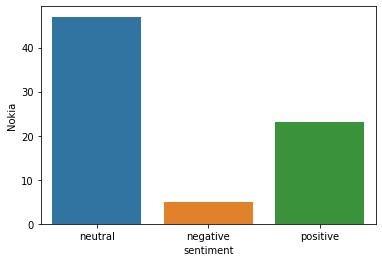

In [22]:
sns.barplot(x='sentiment', y='Nokia', data=total_values)


olá diretores <br>
Como podem ver, o produto de vocês recebem poucas reclamações em comparação a opnião neutra, fazendo dele um ótimo produto no mercado!!

<AxesSubplot:xlabel='sentiment', ylabel='AAPL'>

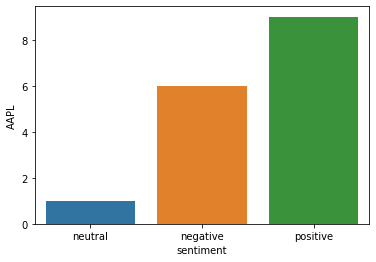

In [23]:
sns.barplot(x='sentiment', y='AAPL', data=total_values)


olá diretores <br>
Como podem ver no gráfico acima, ou as pessas amam o seu produto ou odieam ele 

<AxesSubplot:xlabel='sentiment', ylabel='Finnair'>

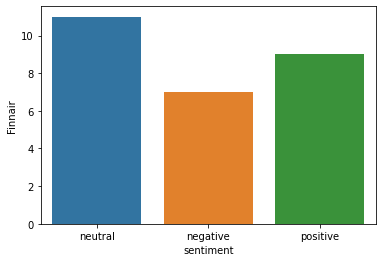

In [24]:
sns.barplot(x='sentiment', y='Finnair', data=total_values)

olá diretores <br>
Como podem ver no gráfico acima, as opniões estão bem dividias entre os consumidores do seu produto!!